=== Image Cache Analytics Report ===
Analysis period: From 2025-02-09 to present

Overall Statistics:
Total images generated: 38
Total images served from cache: 2
Cache hit ratio: 5.00%
Average images generated per day: 19.00
Average images served from cache per day: 1.00

Most 10 Frequently Cached Images:
1) 2x: 009_Heidelbeer_Buttermilch_Ananas_Orange_Smoothie.jpg

Daily Breakdown:


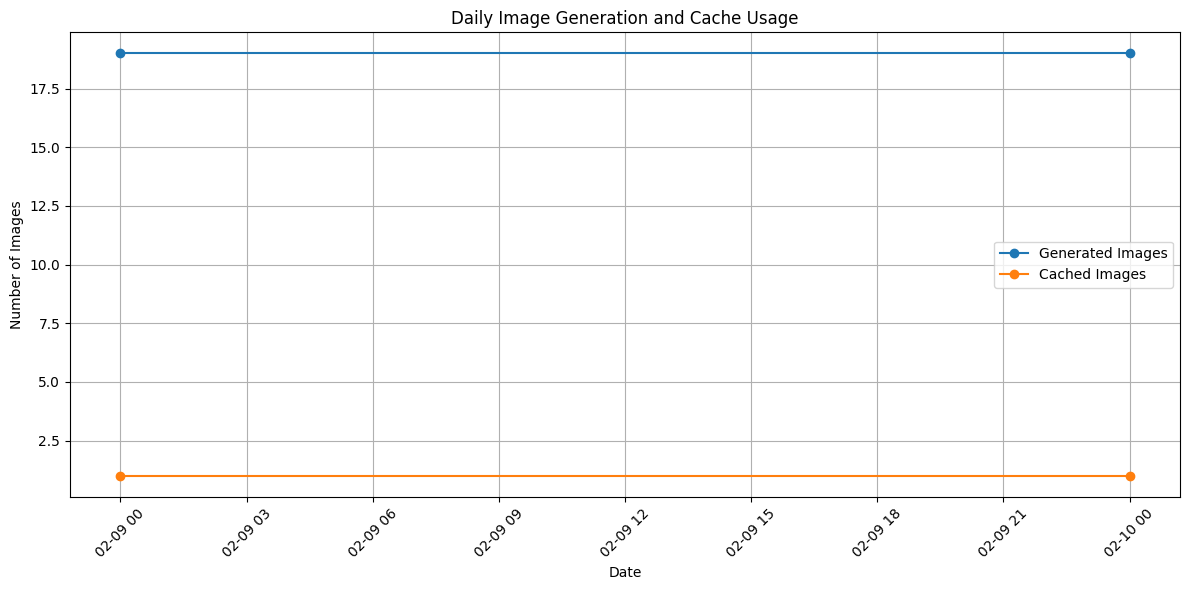


=== Files for 2025-02-10 ===

Generated (fresh) images:
- 2025-02-14/0.jpg
- 031_Kalbsgeschnetzeltes_Züricher_Art_mit_Champignons_Sahne_Eierspätzle.jpg
- unknown
- 2025-02-14/1.jpg
- 032_Hirtenkäse_Spinat_im_Blätterteigmantel_mit_Zitronen_Sahnesoße_Karotten_Spargel_Gemüse_Herzoginkartoffeln.jpg
- unknown
- 2025-02-14/2.jpg
- 033_Veganes_Geschnetzeltes_Züricher_Art_dazu_Schupfnudeln.jpg
- unknown
- 2025-02-14/3.jpg
- 034_Currygemüse_Pfanne_mit_Mango_Cashewkernen_dazu_Reisnudeln.jpg
- unknown
- 2025-02-14/4.jpg
- 035_Currygemüse_Pfanne_mit_Mango_Cashewkernen_mit_Rinderstreifen_oder_Mini_Frühlingsröllchen_dazu_Reisnudeln.jpg
- unknown
- 2025-02-14/5.jpg
- 036_Bolognese_vom_Schwein_Käse_Lauch_Soße_mit_Soja_Bolognese_aus_roten_Linsen.jpg
- unknown
- unknown

Cache served images:
- 009_Heidelbeer_Buttermilch_Ananas_Orange_Smoothie.jpg


In [16]:
from datetime import datetime
import re
from collections import Counter
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import pandas as pd


class ImageCacheAnalytics:
    def __init__(self, log_file: str, start_date: str):
        self.log_file = log_file
        self.start_date = datetime.strptime(start_date, "%Y-%m-%d")

        # We continue to track generated and cache-hit events but now separately.
        self.generated_images: List[Tuple[str, datetime]] = []  # will store (item, timestamp) when filename unknown
        self.cache_hits: List[Tuple[str, datetime]] = []  # will store (filename, timestamp) for cache usage

        # Counters by date (YYYY-MM-DD)
        self.generated_images_by_date: Dict[str, int] = {}
        self.cache_hits_by_date: Dict[str, int] = {}

        # Track filenames by date (for later insight)
        self.generated_filenames_by_date: Dict[str, List[str]] = {}
        self.cache_hit_filenames_by_date: Dict[str, List[str]] = {}

    def parse_log(self):
        with open(self.log_file, "r", encoding="utf-8") as f:
            current_date = None

            for line in f:
                # Parse the date from the beginning of the log line
                date_match = re.match(r"(\d{4}-\d{2}-\d{2})", line)
                if date_match:
                    current_date = datetime.strptime(date_match.group(1), "%Y-%m-%d")
                    if current_date < self.start_date:
                        continue

                    date_str = current_date.strftime("%Y-%m-%d")
                    # Initialize counters and filename lists for this date if not set.
                    if date_str not in self.generated_images_by_date:
                        self.generated_images_by_date[date_str] = 0
                    if date_str not in self.cache_hits_by_date:
                        self.cache_hits_by_date[date_str] = 0
                    if date_str not in self.generated_filenames_by_date:
                        self.generated_filenames_by_date[date_str] = []
                    if date_str not in self.cache_hit_filenames_by_date:
                        self.cache_hit_filenames_by_date[date_str] = []

                # Process cache-hit events first.
                # These lines indicate that an image was found in cache (i.e. reused)
                cached_found_match = re.search(
                    r"Cached image found for '(.+?)'\s+\((\d+_.+?\.jpg)\)",
                    line,
                )
                if cached_found_match and current_date and current_date >= self.start_date:
                    # Extract item name (if needed) and the filename from the log.
                    item_name = cached_found_match.group(1)
                    filename = cached_found_match.group(2)
                    date_str = current_date.strftime("%Y-%m-%d")
                    self.cache_hits.append((filename, current_date))
                    self.cache_hits_by_date[date_str] += 1
                    self.cache_hit_filenames_by_date[date_str].append(filename)
                    continue  # do not process the same line with other patterns

                # Next, capture generated image events from the filename perspective.
                # For generated images we use the log "Image cached at ..." (this is when a generated image is stored to cache).
                gen_cache_match = re.search(
                    r"Image cached at.*?/cache/(\d+_.+?\.jpg)",
                    line,
                )
                if gen_cache_match and current_date and current_date >= self.start_date:
                    filename = gen_cache_match.group(1)
                    date_str = current_date.strftime("%Y-%m-%d")
                    self.generated_filenames_by_date[date_str].append(filename)
                    self.generated_images_by_date[date_str] += 1
                    continue

                # (Optional) Also capture "Image saved in ..." lines for generated images.
                # This is in case the "Image cached at" line is missing.
                saved_match = re.search(r"Image saved in\s+(\S+\.jpg)", line)
                if saved_match and current_date and current_date >= self.start_date:
                    filename = saved_match.group(1)
                    date_str = current_date.strftime("%Y-%m-%d")
                    # If we did not already record this filename, then add it.
                    if filename not in self.generated_filenames_by_date[date_str]:
                        self.generated_filenames_by_date[date_str].append(filename)
                        self.generated_images_by_date[date_str] += 1
                    continue

                # Finally, fallback: if we see the "Image generated successfully" line but did not already count it above.
                # (This branch will often be reached for cache-hit cases, but we already count those from the above branch.)
                generated_match = re.search(
                    r"Image generated successfully for item:\s*(.+)$",
                    line,
                )
                if generated_match and current_date and current_date >= self.start_date:
                    item_name = generated_match.group(1).strip()
                    date_str = current_date.strftime("%Y-%m-%d")
                    # Record the event with an unknown filename if not already recorded.
                    self.generated_images.append((item_name, current_date))
                    self.generated_images_by_date[date_str] += 1
                    # Use a placeholder, if no filename was captured
                    self.generated_filenames_by_date[date_str].append("unknown")
                    continue

    def get_most_cached_images(self, top_n: int = 5) -> List[Tuple[str, int]]:
        # If you wish, you could merge filenames coming from generated vs cache_hits
        # For now, we simply count based on the generated filenames_by_date as an example.
        cache_counts = Counter()
        for date, fn_list in self.cache_hit_filenames_by_date.items():
            for fn in fn_list:
                cache_counts[fn] += 1
        return sorted(cache_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

    def get_avg_generated_per_day(self) -> float:
        if not self.generated_images_by_date:
            return 0.0
        return sum(self.generated_images_by_date.values()) / len(self.generated_images_by_date)

    def get_avg_cached_per_day(self) -> float:
        if not self.cache_hits_by_date:
            return 0.0
        return sum(self.cache_hits_by_date.values()) / len(self.cache_hits_by_date)

    def output_filenames(self):
        print("=== Detailed Files Output ===\n")

        print("Generated Images (events):")
        for item, timestamp in self.generated_images:
            print(f"Generated: {item} at {timestamp.strftime('%Y-%m-%d %H:%M:%S')}")

        print("\nCached Hits (from cache):")
        for filename, timestamp in self.cache_hits:
            print(f"Cache Hit: {filename} at {timestamp.strftime('%Y-%m-%d %H:%M:%S')}")

    def output_insight(self, date_insight: str):
        """
        Given a date string (YYYY-MM-DD), output the filenames that were generated
        and those that were reused from cache on that day.
        """
        print(f"\n=== Files for {date_insight} ===")
        gen_files = self.generated_filenames_by_date.get(date_insight, [])
        cache_files = self.cache_hit_filenames_by_date.get(date_insight, [])

        print("\nGenerated (fresh) images:")
        if gen_files:
            for fn in gen_files:
                print(f"- {fn}")
        else:
            print("No generated images for this date.")

        print("\nCache served images:")
        if cache_files:
            for fn in cache_files:
                print(f"- {fn}")
        else:
            print("No cache hits for this date.")

    def generate_report(self):
        total_generated = sum(self.generated_images_by_date.values())
        total_cache_hits = sum(self.cache_hits_by_date.values())

        print("=== Image Cache Analytics Report ===")
        print(f"Analysis period: From {self.start_date.strftime('%Y-%m-%d')} to present\n")

        print("Overall Statistics:")
        print(f"Total images generated: {total_generated}")
        print(f"Total images served from cache: {total_cache_hits}")
        total_ops = total_generated + total_cache_hits
        hit_ratio = (total_cache_hits / total_ops) * 100 if total_ops > 0 else 0
        print(f"Cache hit ratio: {hit_ratio:.2f}%")
        print(f"Average images generated per day: {self.get_avg_generated_per_day():.2f}")
        print(f"Average images served from cache per day: {self.get_avg_cached_per_day():.2f}\n")

        print("Most 10 Frequently Cached Images:")
        for i, (img, count) in enumerate(self.get_most_cached_images(10), 1):
            print(f"{i}) {count}x: {img}")

        print("\nDaily Breakdown:")
        # Use the keys from generated images count to build the data frame.
        dates = sorted(self.generated_images_by_date.keys())
        generated = [self.generated_images_by_date.get(date, 0) for date in dates]
        cached = [self.cache_hits_by_date.get(date, 0) for date in dates]

        df = pd.DataFrame({"Date": pd.to_datetime(dates), "Generated": generated, "Cached": cached})

        plt.figure(figsize=(12, 6))
        plt.plot(df["Date"], df["Generated"], label="Generated Images", marker="o")
        plt.plot(df["Date"], df["Cached"], label="Cached Images", marker="o")
        plt.title("Daily Image Generation and Cache Usage")
        plt.xlabel("Date")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


def main():
    # Set your start date for analysis
    START_DATE = "2025-02-09"
    # Set the date for which you want file insight
    DATE_INSIGHT = "2025-02-10"

    analyzer = ImageCacheAnalytics("nightly/cron.log", START_DATE)
    analyzer.parse_log()
    analyzer.generate_report()
    # Output the detailed filenames from the log events (raw events)
    # analyzer.output_filenames()
    # Output the filenames for a single date (freshly generated vs reused from cache)
    analyzer.output_insight(DATE_INSIGHT)


if __name__ == "__main__":
    main()